In [3]:
# ===========================================
# STEP 1: IMPORT LIBRARIES
# ===========================================
import numpy as np
import pandas as pd
import re
import string
import emoji
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Download required NLTK data (quietly)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [5]:
# ===========================================
# STEP 2: LOAD LABELED DATASETS
# ===========================================

# ---------- FILE PATHS ----------
twitter_path = r"training.1600000.processed.noemoticon.csv"
reddit_path = r"goemotions_1.csv"

# ---------- SENTIMENT140 (TWITTER) ----------
if os.path.exists(twitter_path):
    df_twitter = pd.read_csv(twitter_path, encoding='latin-1', header=None)
    df_twitter.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
    df_twitter = df_twitter[['text', 'target']]
    df_twitter['target'] = df_twitter['target'].replace(4, 1) # 4 -> 1 (positive)
    print(f"✅ Twitter dataset loaded: {df_twitter.shape[0]} samples")
else:
    df_twitter = pd.DataFrame(columns=['text', 'target'])
    print("⚠️ Twitter dataset not found!")

# ---------- GOEMOTIONS (REDDIT) ----------
if os.path.exists(reddit_path):
    df_reddit = pd.read_csv(reddit_path)

    # Determine sentiment based on emotion columns
    emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval',
                    'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
                    'disapproval', 'disgust', 'embarrassment', 'excitement',
                    'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness',
                    'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
                    'surprise']

    # Create 'target' column based on positive/negative emotions
    positive_emotions = ['admiration', 'amusement', 'approval', 'caring', 'desire',
                         'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride',
                         'realization', 'relief', 'surprise']
    negative_emotions = ['anger', 'annoyance', 'confusion', 'curiosity', 'disappointment',
                         'disapproval', 'disgust', 'embarrassment', 'fear', 'grief',
                         'nervousness', 'remorse', 'sadness']

    # Assign 1 for positive, 0 for negative, and drop neutral/mixed
    df_reddit['target'] = -1 # Initialize with -1

    # Assign 1 if any positive emotion is present (and no negative emotions are present)
    df_reddit.loc[(df_reddit[positive_emotions].sum(axis=1) > 0) & (df_reddit[negative_emotions].sum(axis=1) == 0), 'target'] = 1

    # Assign 0 if any negative emotion is present (and no positive emotions are present)
    df_reddit.loc[(df_reddit[negative_emotions].sum(axis=1) > 0) & (df_reddit[positive_emotions].sum(axis=1) == 0), 'target'] = 0

    # Filter out rows that are still -1 (neutral or mixed emotions)
    df_reddit = df_reddit[df_reddit['target'] != -1].copy()

    df_reddit = df_reddit[['text', 'target']]
    print(f"✅ Reddit dataset loaded: {df_reddit.shape[0]} samples (neutrals and mixed removed)")
else:
    df_reddit = pd.DataFrame(columns=['text', 'target'])
    print("⚠️ Reddit dataset not found!")

# ---------- COMBINE AND SHUFFLE ----------
data = pd.concat([df_twitter, df_reddit], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Final combined dataset ready!")
print(f"📊 Total samples: {data.shape[0]}")
print("Class distribution:\n", data['target'].value_counts())

✅ Twitter dataset loaded: 42373 samples
✅ Reddit dataset loaded: 20913 samples (neutrals and mixed removed)

✅ Final combined dataset ready!
📊 Total samples: 63286
Class distribution:
 target
0    51007
1    12279
Name: count, dtype: int64


In [6]:
# ===========================================
# STEP 3: DEFINE TEXT CLEANING FUNCTION
# ===========================================

# Initialize reusable objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)                     # Remove mentions
    text = text.replace("#", "")                         # Remove hashtags symbol
    text = emoji.demojize(text)                          # Convert emojis to words
    text = text.replace(":", " ").replace("_", " ")      # Clean up emoji text
    text = re.sub(r"[^a-z\s]", "", text)                  # Remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip()              # Collapse multiple spaces

    # Tokenize, lemmatize, and remove stopwords
    tokens = [
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words
    ]
    return " ".join(tokens)

In [8]:
# ===========================================
# STEP 4: APPLY TEXT CLEANING
# ===========================================

# Apply the cleaning function to the 'text' column
data['clean_text'] = data['text'].apply(clean_text)

# ===========================================
# STEP 5: TOKENIZATION & PADDING
# ===========================================

# Features and labels
X = data['clean_text']
y = data['target']

# Train-test split (80-20), stratifying to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenize text
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences and pad them
maxlen = 100
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen, padding='post', truncating='post')

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"✅ Vocabulary size: {vocab_size:,}")
print(f"✅ Training samples: {X_train_pad.shape[0]}")
print(f"✅ Testing samples: {X_test_pad.shape[0]}")
print(f"✅ Max sequence length: {maxlen}")

✅ Vocabulary size: 33,380
✅ Training samples: 50628
✅ Testing samples: 12658
✅ Max sequence length: 100


In [10]:
# ===========================================
# STEP 6: LOAD GLOVE EMBEDDINGS
# ===========================================
glove_path = r"glove.twitter.27B.100d.txt"
embedding_dim = 100

print("⏳ Loading GloVe embeddings...")
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        # Add a check to ensure the vector has the correct dimension
        if len(vector) == embedding_dim:
            embedding_index[word] = vector
        else:
            print(f"Skipping word '{word}' with unexpected vector size: {len(vector)}")


print(f"✅ Loaded {len(embedding_index):,} word vectors from GloVe.")

# Build the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

coverage = hits / vocab_size * 100
print(f"✅ Embedding matrix ready: {embedding_matrix.shape}")
print(f"    → {hits:,} words found ({coverage:.2f}% coverage)")
print(f"    → {misses:,} words missing from GloVe")

⏳ Loading GloVe embeddings...
Skipping word 'amigo' with unexpected vector size: 60
Skipping word 'brp' with unexpected vector size: 89
Skipping word 'hujan' with unexpected vector size: 59
✅ Loaded 3,677 word vectors from GloVe.
✅ Embedding matrix ready: (33380, 100)
    → 1,846 words found (5.53% coverage)
    → 31,533 words missing from GloVe


In [12]:
# ===========================================
# STEP 7: BUILD MODELS (WITH SUMMARY FIX)
# ===========================================

# --- Attention Layer (for BiLSTM) ---
class AttentionLayer(Layer):
    def call(self, inputs):
        score = K.softmax(K.sum(inputs, axis=2))
        score = K.expand_dims(score, axis=-1)
        context = inputs * score
        context = K.sum(context, axis=1)
        return context

# --- Model 1: Simple RNN ---
rnn_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=maxlen,
        trainable=False
    ),
    SimpleRNN(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# ✅ FIX: Manually build the model to view the summary
rnn_model.build(input_shape=(None, maxlen))
print("\n✅ Simple RNN Model Summary:")
rnn_model.summary()


# --- Model 2: BiLSTM + Attention ---
bilstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=maxlen,
        trainable=False
    ),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
    AttentionLayer(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# ✅ FIX: Manually build the model to view the summary
bilstm_model.build(input_shape=(None, maxlen))
print("\n✅ BiLSTM + Attention Model Summary:")
bilstm_model.summary()


✅ Simple RNN Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     3,338,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,367,441 (12.85 MB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 3,338,000 (12.73 MB)


✅ BiLSTM + Attention Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     3,338,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 256)            │             0 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,589,009 (13.69 MB)

 Trainable params: 251,009 (980.50 KB)

 Non-trainable params: 3,338,000 (12.73 MB)

In [15]:
# ===========================================
# STEP 8: TRAIN MODELS
# ===========================================
EPOCHS = 10  # A more reasonable number of epochs
BATCH_SIZE = 128

# Callback to stop training early if validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,           # Wait 2 epochs before stopping
    restore_best_weights=True
)

print("\n🚀 Training Simple RNN model...")
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.1, # Use 10% of training data for validation
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

print("\n🚀 Training BiLSTM + Attention model...")
history_bilstm = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)


🚀 Training Simple RNN model...
Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - accuracy: 0.8067 - loss: 0.4939 - val_accuracy: 0.8094 - val_loss: 0.4877
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.8056 - loss: 0.4944 - val_accuracy: 0.8094 - val_loss: 0.4874
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - accuracy: 0.8041 - loss: 0.4966 - val_accuracy: 0.8094 - val_loss: 0.4871
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - accuracy: 0.8042 - loss: 0.4957 - val_accuracy: 0.8094 - val_loss: 0.4871
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.8051 - loss: 0.4939 - val_accuracy: 0.8094 - val_loss: 0.4876
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.8061 - loss: 0.4926 - val_accuracy: 0.8094 - val_loss: 0.4872

🚀 Training BiLSTM + Attention model...
Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.8136 - loss: 0.4380 - val_accuracy: 0.8582 - val_loss: 0.3449
Epoch 2/10
35

In [16]:
# ===========================================
# STEP 9: EVALUATION & COMPARISON
# ===========================================
def evaluate_model(model, X_test, y_test):
    """Predicts and calculates key metrics for a given model."""
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec, y_pred

# Evaluate both models
rnn_acc, rnn_f1, rnn_prec, rnn_rec, y_pred_rnn = evaluate_model(rnn_model, X_test_pad, y_test)
bilstm_acc, bilstm_f1, bilstm_prec, bilstm_rec, y_pred_bilstm = evaluate_model(bilstm_model, X_test_pad, y_test)

# Create a comparison DataFrame
results_df = pd.DataFrame({
    'Model': ['Simple RNN', 'BiLSTM + Attention'],
    'Accuracy': [rnn_acc, bilstm_acc],
    'F1-Score': [rnn_f1, bilstm_f1],
    'Precision': [rnn_prec, bilstm_prec],
    'Recall': [rnn_rec, bilstm_rec]
}).set_index('Model')

print("\n📊 Model Performance Comparison on Test Data:")
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Model Performance Comparison on Test Data:
                    Accuracy  F1-Score  Precision    Recall
Model                                                      
Simple RNN          0.805973  0.000000   0.000000  0.000000
BiLSTM + Attention  0.856849  0.548355   0.706941  0.447883


/tmp/ipython-input-676727228.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-676727228.py:24: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


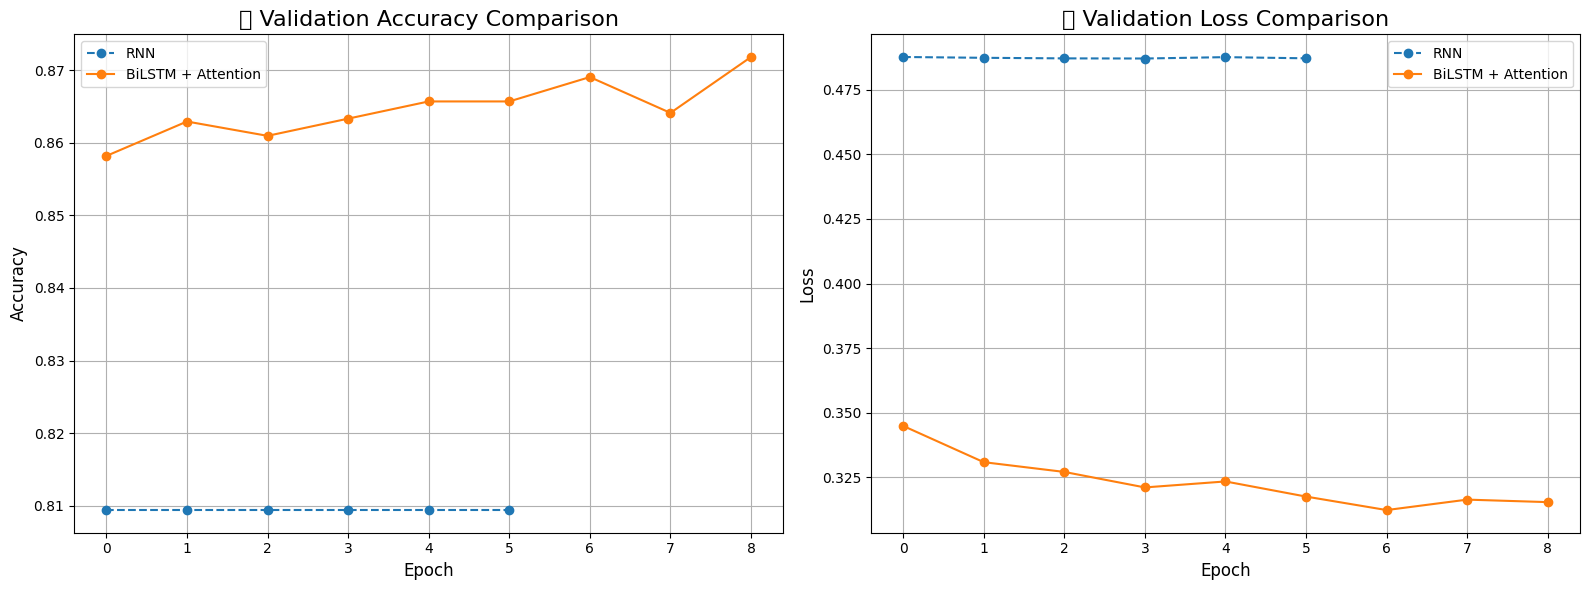

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


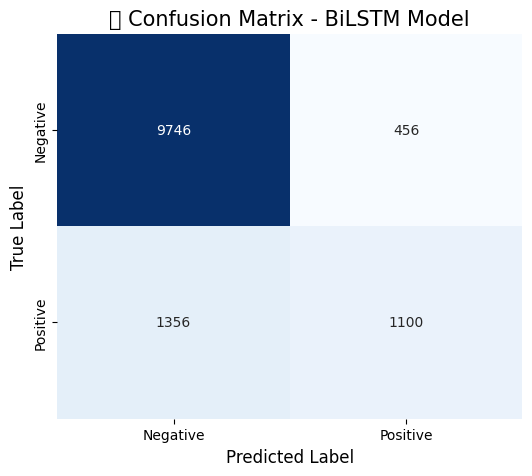

In [17]:
# ===========================================
# STEP 10: VISUALIZE RESULTS
# ===========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Validation Accuracy
ax1.plot(history_rnn.history['val_accuracy'], label='RNN', marker='o', linestyle='--')
ax1.plot(history_bilstm.history['val_accuracy'], label='BiLSTM + Attention', marker='o', linestyle='-')
ax1.set_title('📈 Validation Accuracy Comparison', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: Validation Loss
ax2.plot(history_rnn.history['val_loss'], label='RNN', marker='o', linestyle='--')
ax2.plot(history_bilstm.history['val_loss'], label='BiLSTM + Attention', marker='o', linestyle='-')
ax2.set_title('📉 Validation Loss Comparison', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


# Plot 3: Confusion Matrix for the BiLSTM Model
cm = confusion_matrix(y_test, y_pred_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("🔍 Confusion Matrix - BiLSTM Model", fontsize=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()